Rotated images matched against references using Gabor filter banks:
original: brick, rotated: 30deg, match result: brick
original: brick, rotated: 70deg, match result: brick
original: grass, rotated: 145deg, match result: grass


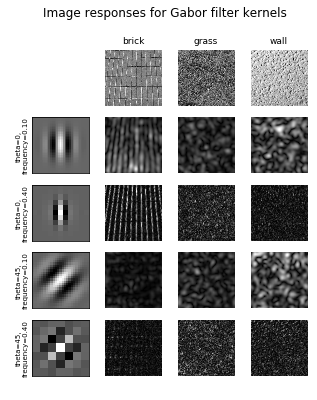

In [2]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel


def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats


def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i


# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)


shrink = (slice(0, None, 3), slice(0, None, 3))
brick = img_as_float(data.load('brick.png'))[shrink]
grass = img_as_float(data.load('grass.png'))[shrink]
wall = img_as_float(data.load('rough-wall.png'))[shrink]
image_names = ('brick', 'grass', 'wall')
images = (brick, grass, wall)

# prepare reference features
ref_feats = np.zeros((3, len(kernels), 2), dtype=np.double)
ref_feats[0, :, :] = compute_feats(brick, kernels)
ref_feats[1, :, :] = compute_feats(grass, kernels)
ref_feats[2, :, :] = compute_feats(wall, kernels)

print('Rotated images matched against references using Gabor filter banks:')

print('original: brick, rotated: 30deg, match result: ', end='')
feats = compute_feats(ndi.rotate(brick, angle=190, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: brick, rotated: 70deg, match result: ', end='')
feats = compute_feats(ndi.rotate(brick, angle=70, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: grass, rotated: 145deg, match result: ', end='')
feats = compute_feats(ndi.rotate(grass, angle=145, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])


def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(5, 6))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel), interpolation='nearest')
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()

In [6]:
import cv2
import numpy as np
import pylab as pl
import glob
import pandas as pd

# define gabor filter bank with different orientations and at different scales
def build_filters():
	filters = []
	ksize = 31
	#define the range for theta and nu
	for theta in np.arange(0, np.pi, np.pi / 8):
		for nu in np.arange(0, 6*np.pi/4 , np.pi / 4):
			kern = cv2.getGaborKernel((ksize, ksize), 1.0, theta, nu, 0.5, 0, ktype=cv2.CV_32F)
			kern /= 1.5*kern.sum()
			filters.append(kern)
	return filters

#function to convolve the image with the filters
def process(img, filters):
	accum = np.zeros_like(img)
	for kern in filters:
		fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
		np.maximum(accum, fimg, accum)
	return accum

if __name__ == '__main__':

	#instantiating the filters
	filters = build_filters()

	f = np.asarray(filters)

	#reading the input image
	imgg = cv2.imread('C:/b/2.jpg',0)
	
	#initializing the feature vector
	feat = []

	#calculating the local energy for each convolved image
	for j in range(40):
		res = process(imgg, f[j])
		temp = 0
		for p in range(5):
			for q in range(5):
				temp = temp + res[p][q]*res[p][q]
		feat.append(temp)
	#calculating the mean amplitude for each convolved image	
	for j in range(40):
		res = process(imgg, f[j])
		temp = 0
		for p in range(5):
			for q in range(5):
				temp = temp + abs(res[p][q])
		feat.append(temp)

C:\Users\69654\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in ubyte_scalars


In [7]:
print (feat)

[0, 3567, 3571, 3178, 3526, 3647, 0, 25, 25, 3115, 1668, 4227, 0, 3385, 2592, 4154, 3260, 1440, 0, 60, 25, 25, 3385, 2758, 0, 3168, 25, 25, 25, 3252, 0, 60, 25, 25, 3385, 2758, 0, 3385, 2557, 4154, 0, 499, 499, 488, 498, 501, 0, 6375, 6375, 609, 574, 557, 0, 689, 4374, 1262, 942, 818, 0, 6126, 6375, 6375, 2729, 1788, 0, 4432, 6375, 6375, 6375, 3646, 0, 6126, 6375, 6375, 2729, 1788, 0, 689, 4375, 1262]


In [5]:
print (feat)

[0, 2739, 2787, 2771, 2741, 2720, 0, 25, 25, 3919, 3664, 3386, 0, 5200, 3046, 3531, 3277, 2104, 0, 25, 25, 2710, 2469, 2573, 0, 2991, 127, 25, 3462, 2931, 0, 25, 25, 2710, 2469, 2573, 0, 5200, 3046, 3531, 0, 261, 263, 261, 261, 260, 0, 6375, 6375, 321, 302, 290, 0, 360, 3300, 671, 491, 424, 0, 6375, 6375, 3594, 1427, 931, 0, 2281, 6357, 6375, 3862, 1883, 0, 6375, 6375, 3594, 1427, 931, 0, 360, 3300, 671]
